In [1]:
from pyspark.sql.functions import *
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime

%matplotlib inline
sc.setLogLevel("ERROR")

# Description of the dataset

One file per month is provided as a csv file with the following
features:

- **callsign**: the identifier of the flight displayed on ATC screens
  (usually the first three letters are reserved for an airline: AFR
  for Air France, DLH for Lufthansa, etc.)
- **number**: the commercial number of the flight, when available (the
  matching with the callsign comes from public open API)
- **icao24**: the transponder unique identification number;
- **registration**: the aircraft tail number (when available);
- **typecode**: the aircraft model type (when available);
- **origin**: a four letter code for the origin airport of the flight
  (when available);
- **destination**: a four letter code for the destination airport of
  the flight (when available);
- **firstseen**: the UTC timestamp of the first message received by
  the OpenSky Network;
- **lastseen**: the UTC timestamp of the last message received by the
  OpenSky Network;
- **day**: the UTC day of the last message received by the OpenSky
  Network.

# Simple Data Separation and Exploration

In [2]:
df = spark.read.csv('/user/s1919377/flights/*', header='true')
df = df.withColumn('firstseen',to_timestamp('firstseen', 'yyyy-MM-dd HH:mm:ss')) \
       .withColumn('lastseen',to_timestamp('lastseen', 'yyyy-MM-dd HH:mm:ss')) \
       .withColumn('month',to_timestamp('day', 'yyyy-MM')) \
       .withColumn('longitude_1',col('longitude_1').cast('float')) \
       .withColumn('longitude_2',col('longitude_2').cast('float')) \
       .withColumn('latitude_1',col('latitude_1').cast('float')) \
       .withColumn('latitude_2',col('latitude_2').cast('float')) \
       .withColumn('altitude_1',col('altitude_1').cast('float')) \
       .withColumn('altitude_2',col('altitude_2').cast('float'))
df.show(truncate=False)
df.printSchema()

+--------+------+------+------------+--------+------+-----------+-------------------+-------------------+-------------------------+----------+-----------+----------+----------+-----------+----------+-------------------+
|callsign|number|icao24|registration|typecode|origin|destination|firstseen          |lastseen           |day                      |latitude_1|longitude_1|altitude_1|latitude_2|longitude_2|altitude_2|month              |
+--------+------+------+------------+--------+------+-----------+-------------------+-------------------+-------------------------+----------+-----------+----------+----------+-----------+----------+-------------------+
|CCA961  |CA961 |780c9e|B-2006      |B77W    |KLAX  |EDDM       |2019-07-31 00:10:20|2019-08-01 04:44:16|2019-08-01 00:00:00+00:00|33.946915 |-118.432335|0.0       |48.367355 |11.827346  |426.72    |2019-08-01 00:00:00|
|KQA210  |KQ210 |04c149|5Y-CYC      |B738    |FAOR  |VABB       |2019-07-31 00:25:06|2019-08-01 10:54:26|2019-08-01 00:0

In [3]:
df_baseline = df.where(col('day').contains('2019-01'))
df_progression = df.where(~col('day').contains('2019-01'))
df1 = df_baseline.groupBy('origin').count().sort(col('count').desc()).dropna()
df2 = df_progression.groupBy('origin', 'month').count().sort(col('count').desc()).dropna()
df1.show(10)
df2.show(10)

+------+-----+
|origin|count|
+------+-----+
|  KLAX|22459|
|  KDFW|21694|
|  KORD|20929|
|  OMDB|18121|
|  VIDP|17493|
|  EGLL|16749|
|  LTBA|16662|
|  KLAS|15709|
|  EDDF|15592|
|  KDEN|15496|
+------+-----+
only showing top 10 rows

+------+-------------------+-----+
|origin|              month|count|
+------+-------------------+-----+
|  KORD|2019-10-01 00:00:00|37250|
|  KORD|2019-08-01 00:00:00|35264|
|  KORD|2019-12-01 00:00:00|35257|
|  KORD|2019-11-01 00:00:00|34783|
|  KATL|2020-01-01 00:00:00|34765|
|  KORD|2021-07-01 00:00:00|34244|
|  KATL|2019-12-01 00:00:00|34105|
|  KATL|2020-02-01 00:00:00|33531|
|  KORD|2020-01-01 00:00:00|33527|
|  KATL|2019-07-01 00:00:00|33475|
+------+-------------------+-----+
only showing top 10 rows



In [4]:
# Take the 100 most populair airports from 2019-01
df1_limit = df1.limit(100)
pd1 = df1_limit.toPandas()

pd1.to_csv('distribution-panda-' + df_baseline.first()['month'].date().strftime('%Y-%m') + '.csv')

# Take the same airports from the dataframe with everything after 2019-01
df2_limit = df2.filter(df2.origin.isin(pd1['origin'].values.tolist()))
try:
    df2_limit.write.csv('df2_limit.csv')
except:
    print('df2_limit.csv already exists')

df2_limit.csv already exists


In [5]:
# Create an array of Pandas DataFrames, where each DataFrame contains the one month after 2019-01, 
# with the origin count per airport

# df2_limit = pd.read_csv('df2_limit.csv')

df2_rest = df2_limit.sort(col('month').asc())

# Check which DataFrames already exist as csv
filenames = os.listdir('.')
existing_months = []
for f in filenames:
    if f.startswith('distribution-panda-'):
        existing_months.append(datetime.datetime.strptime(f[len('distribution-panda-'):-len('.csv')], '%Y-%m'))
df2_rest = df2_rest.filter(~df2_rest.month.isin(existing_months))

while (df2_rest.count() > 0):
    month = df2_rest.first()['month']
    df2_month = df2_rest.limit(100).where(col('month') == month)
    pd2 = df2_month.toPandas()
    # Put this new DataFrame in the same order as the first DataFrame
    pd2['index'] = pd2.apply(lambda row: pd1[pd1['origin'] == row['origin']].index.tolist()[0], axis=1)
    pd2 = pd2.set_index('index').sort_index()
    pd2.to_csv('distribution-panda-' + month.date().strftime('%Y-%m' + '.csv'))
    
    df2_rest = df2_rest.subtract(df2_month)

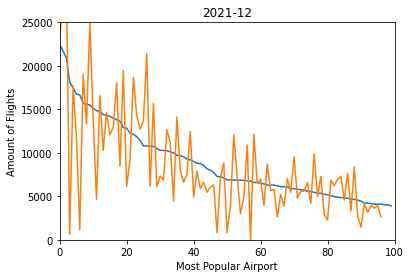

In [7]:
# Animate the progression of the air traffic distribution

# Show the distribution of air traffic over the airports on the first day
fig, ax = plt.subplots()

plt.xlabel('Most Popular Airport')
plt.ylabel('Amount of Flights')

ax.set_xlim(0, 100)
ax.set_ylim(0, 25000)

ax.plot(pd1.index, pd1['count'])

line, = ax.plot([], [])

def init():
    line.set_data([], [])
    return line,

pds_files = []
filenames = os.listdir('.')
for f in filenames:
    if f.startswith('distribution-panda-'):
        pds_files.append(f)

def animate(i):
    pd_progress = pd.read_csv('./' + pds_files[i])
    
    plt.title(pds_files[i][len('distribution-panda-'):-len('.csv')])
    
    line.set_data(pd_progress.index, pd_progress["count"])
    
    return line,
    
anim = FuncAnimation(fig, animate, init_func = init, frames = len(pds_files), interval = 500)
HTML(anim.to_html5_video())